In [86]:
#1.Подготовка библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
# 2. Чтение файлов, анализ данных

# Чтение файлов

financial_data = pd.read_csv('/content/gdrive/MyDrive/Тестовое задание (аналитика данных)/financial_data.csv')
prolongations = pd.read_csv('/content/gdrive/MyDrive/Тестовое задание (аналитика данных)/prolongations.csv')
#financial_data.head(500)
financial_data.tail()
#prolongations.head(500)

,id,Причина дубля,Ноябрь 2022,Декабрь 2022,Январь 2023,Февраль 2023,Март 2023,Апрель 2023,Май 2023,Июнь 2023,Июль 2023,Август 2023,Сентябрь 2023,Октябрь 2023,Ноябрь 2023,Декабрь 2023,Январь 2024,Февраль 2024,Account
446,281,основные работы,"76 550,00","79 950,00","66 900,00","89 150,00","108 450,00","77 100,00","78 800,00","126 740,00","117 730,00","115 860,00","160 770,00","142 490,00","99 125,00","74 350,00","105 775,00","92 065,00",Соколова Анастасия Викторовна
447,281,доп работы,"21 450,00","13 300,00","15 900,00","19 850,00","17 350,00","14 650,00","15 900,00","3 000,00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Соколова Анастасия Викторовна
448,785,NaN,NaN,NaN,NaN,"5 306,60","12 898,10","5 287,00","10 180,00","8 600,00","3 860,00","8 600,00","700,00","700,00",в ноль,в ноль,NaN,NaN,Соколова Анастасия Викторовна
449,913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"58 200,00","58 200,00","58 200,00","58 200,00","58 200,00","58 200,00",NaN,NaN,Смирнова Ольга Владимировна
450,930,первая часть оплаты,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"36 687,50","31 152,50","30 350,00","34 547,50","25 750,00","25 600,00",Кузнецов Михаил Иванович


In [10]:
# 3. Подготовка данных к работе
df_financial_data = pd.DataFrame(financial_data)
df_prolongations = pd.DataFrame(prolongations)
df_financial_data.fillna(0, inplace=True) #Заполнение пустых полей 0
#financial_data.head(20)

def clean_financial(df):
    df = df.copy()
    months = [c for c in df.columns if c not in ['id','Account','Причина дубля']]

    # Поиск стоп-проектов до конвертации
    stop_mask = df[months].astype(str).apply(
        lambda x: x.str.contains('стоп|end', case=False, regex=True)
    ).any(axis=1)
    stop_ids = df.loc[stop_mask, 'id'].unique()

    # Числовые суммы
    for m in months:
        df[m] = (df[m].astype(str)
                       .str.replace('\xa0', '')
                       .str.replace(' ', '')
                       .str.replace(',', '.')
                       .replace('вноль', '0'))
        df[m] = pd.to_numeric(df[m], errors='coerce').fillna(0)

    df = df[~df['id'].isin(stop_ids)]
    return df, months

def merge_data(df_fin, df_prol):
    df_prol = df_prol.sort_values(['id', 'month']).drop_duplicates('id', keep='last')
    return df_fin.merge(df_prol[['id','AM','month']], on='id', how='inner')



In [67]:
# 4. Рассчет коэффициентов

MONTH_ORDER = [
    'январь','февраль','март','апрель','май','июнь',
    'июль','август','сентябрь','октябрь','ноябрь','декабрь'
]

def sort_months(months):
    return sorted(months, key=lambda x: (
        int(x.split()[1]),
        MONTH_ORDER.index(x.split()[0].lower())
    ))

def compute_k1(df, last_month, next_month):
    # Проекты, завершившиеся в last_month (последняя отгрузка)
    completed_projects = df[df[last_month] > 0]

    # Пролонгированные в next_month (первый месяц после завершения)
    prolonged = completed_projects[completed_projects[next_month] > 0]

    num = prolonged[next_month].sum()  # отгрузка пролонгированных
    den = completed_projects[last_month].sum()  # отгрузка в последнем месяце завершенных

    return num / den if den > 0 else 0, num, den

def compute_k2(df, last_month, skip_month, recovery_month):
    # Проекты, завершившиеся в last_month
    completed_projects = df[df[last_month] > 0]

    # НЕ пролонгированные в skip_month (первый месяц после завершения)
    not_prolonged_month1 = completed_projects[completed_projects[skip_month] == 0]

    # Но пролонгированные в recovery_month (второй месяц после завершения)
    prolonged_month2 = not_prolonged_month1[not_prolonged_month1[recovery_month] > 0]

    num = prolonged_month2[recovery_month].sum()  # отгрузка пролонгированных во 2-й месяц
    den = not_prolonged_month1[last_month].sum()  # отгрузка в последнем месяце НЕ пролонгированных в 1-й месяц

    return num / den if den > 0 else 0, num, den

def calc_monthly_coeffs(df, months, by_manager=False):
    months = sort_months(months)
    results = []

    groups = df.groupby("AM") if by_manager else [('Отдел', df)]

    for name, group in groups:
        for i in range(len(months) - 2):  # Нужно как минимум 3 месяца: завершение + 2 месяца наблюдения
            last_month = months[i]        # месяц завершения (последняя отгрузка)
            first_month_after = months[i+1]  # первый месяц после завершения
            second_month_after = months[i+2] # второй месяц после завершения

            k1, k1_n, k1_d = compute_k1(group, last_month, first_month_after)
            k2, k2_n, k2_d = compute_k2(group, last_month, first_month_after, second_month_after)

            results.append({
                "Manager": name,
                "Completion_Month": last_month,  # месяц завершения проектов
                "K1": k1,
                "K2": k2,
                "K1_numerator": k1_n,
                "K1_denominator": k1_d,
                "K2_numerator": k2_n,
                "K2_denominator": k2_d
            })
    return pd.DataFrame(results)

def calc_year_coeffs(df, months, by_manager=False, year=None): #рассчет за весь период
    # Сначала получаем помесячные данные
    monthly_data = calc_monthly_coeffs(df, months, by_manager=by_manager)

    if len(monthly_data) == 0:
        return pd.DataFrame()

    # Определяем период для отображения
    if year:
        period_label = f"{year} год"
    else:
        # Автоматически определяем год из месяцев
        years = list(set([m.split()[-1] for m in months]))
        if len(years) == 1:
            period_label = f"{years[0]} год"
        else:
            period_label = f"{min(years)}-{max(years)}"

    if by_manager:
        results = []
        for manager in monthly_data['Manager'].unique():
            manager_data = monthly_data[monthly_data['Manager'] == manager]

            # Суммируем все числители и знаменатели за весь период
            k1_overall = (manager_data['K1_numerator'].sum() /
                         manager_data['K1_denominator'].sum() if manager_data['K1_denominator'].sum() > 0 else 0)
            k2_overall = (manager_data['K2_numerator'].sum() /
                         manager_data['K2_denominator'].sum() if manager_data['K2_denominator'].sum() > 0 else 0)

            results.append({
                "Manager": manager,
                "Period": period_label,
                "K1": k1_overall,
                "K2": k2_overall,
                "K1_numerator": manager_data['K1_numerator'].sum(),
                "K1_denominator": manager_data['K1_denominator'].sum(),
                "K2_numerator": manager_data['K2_numerator'].sum(),
                "K2_denominator": manager_data['K2_denominator'].sum()
            })
        return pd.DataFrame(results)
    else:
        # Для всего отдела
        k1_overall = (monthly_data['K1_numerator'].sum() /
                     monthly_data['K1_denominator'].sum() if monthly_data['K1_denominator'].sum() > 0 else 0)
        k2_overall = (monthly_data['K2_numerator'].sum() /
                     monthly_data['K2_denominator'].sum() if monthly_data['K2_denominator'].sum() > 0 else 0)

        return pd.DataFrame([{
            "Period": period_label,
            "K1": k1_overall,
            "K2": k2_overall,
            "K1_numerator": monthly_data['K1_numerator'].sum(),
            "K1_denominator": monthly_data['K1_denominator'].sum(),
            "K2_numerator": monthly_data['K2_numerator'].sum(),
            "K2_denominator": monthly_data['K2_denominator'].sum()
        }])

In [72]:
# 5. Визуальзация решения

# 5.1. Ежемесячный рассчет коэффициентов пролонгации по менеджерам

# Чистим финансовые данные
df_fin_clean, all_months = clean_financial(df_financial_data)

# Объединяем с prolongations
df_final = merge_data(df_fin_clean, df_prolongations)

year = 2023
months_for_year = [m for m in all_months if str(year) in m]

# Расчет месячных коэффициентов
monthly = calc_monthly_coeffs(df_final, months_for_year, by_manager=True)

# Фильтруем конкретного менеджера
manager_name = "Попова Екатерина Николаевна"
monthly_manager = monthly[monthly["Manager"] == manager_name]

# Оставляем только нужные колонки и переименовываем для красоты
monthly_manager_clean = monthly_manager[['Manager','Completion_Month', 'K1', 'K2']]
monthly_manager_clean




,Manager,Completion_Month,K1,K2
50,Попова Екатерина Николаевна,Январь 2023,0.866304,0.000000
51,Попова Екатерина Николаевна,Февраль 2023,0.945408,0.190907
52,Попова Екатерина Николаевна,Март 2023,0.818454,0.000000
53,Попова Екатерина Николаевна,Апрель 2023,0.903755,0.000000
54,Попова Екатерина Николаевна,Май 2023,0.902551,0.000000
55,Попова Екатерина Николаевна,Июнь 2023,0.827540,0.009570
56,Попова Екатерина Николаевна,Июль 2023,0.976074,0.000000
57,Попова Екатерина Николаевна,Август 2023,0.962305,0.216839
58,Попова Екатерина Николаевна,Сентябрь 2023,0.869603,0.127711
59,Попова Екатерина Николаевна,Октябрь 2023,0.865506,0.665379


In [79]:
# 5.2. Годовой рассчет коэффициентов пролонгации по отделу

# После расчета оставляем только нужные колонки
#year = 2023
#months_for_year = [m for m in all_months if str(year) in m]
months_for_year = [m for m in all_months if any(str(year) in m for year in [2022, 2023, 2024])]

# Расчет
result = calc_year_coeffs(df_final, months_for_year, by_manager=False, year="2022-2024")

# Оставляем только K1 и K2
final_result = result[['Period', 'K1', 'K2']]
final_result

,Period,K1,K2
0,2022-2024 год,0.853576,0.100263


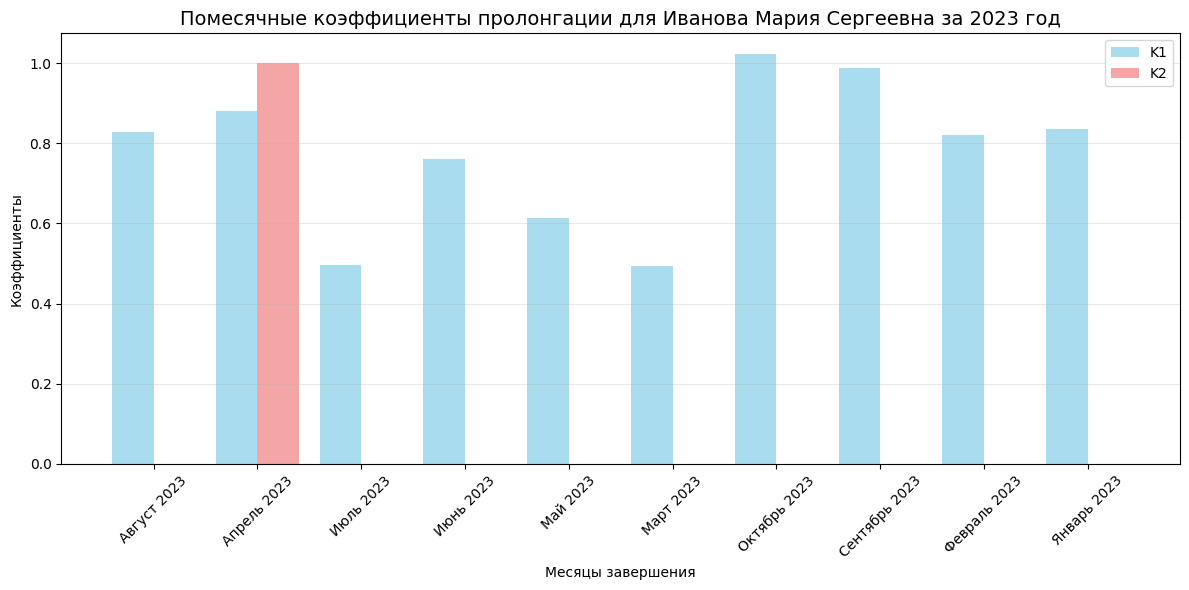

In [89]:
# График коэффициентов за год по одному менеджеру
year = 2023
manager_name = "Иванова Мария Сергеевна"
months_for_year = [m for m in all_months if str(year) in m]

# Расчет месячных коэффициентов
monthly = calc_monthly_coeffs(df_final, months_for_year, by_manager=True)
monthly_manager = monthly[monthly["Manager"] == manager_name]

# Сортируем по месяцам
monthly_manager_sorted = monthly_manager.sort_values('Completion_Month')

plt.figure(figsize=(12, 6))
x_pos = range(len(monthly_manager_sorted))

plt.bar(x_pos, monthly_manager_sorted['K1'], alpha=0.7, color='skyblue', label='K1', width=0.4)
plt.bar([x + 0.4 for x in x_pos], monthly_manager_sorted['K2'], alpha=0.7, color='lightcoral', label='K2', width=0.4)

plt.xticks([x + 0.2 for x in x_pos], monthly_manager_sorted['Completion_Month'], rotation=45)
plt.title(f'Помесячные коэффициенты пролонгации для {manager_name} за {year} год', fontsize=14)
plt.ylabel('Коэффициенты')
plt.xlabel('Месяцы завершения')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

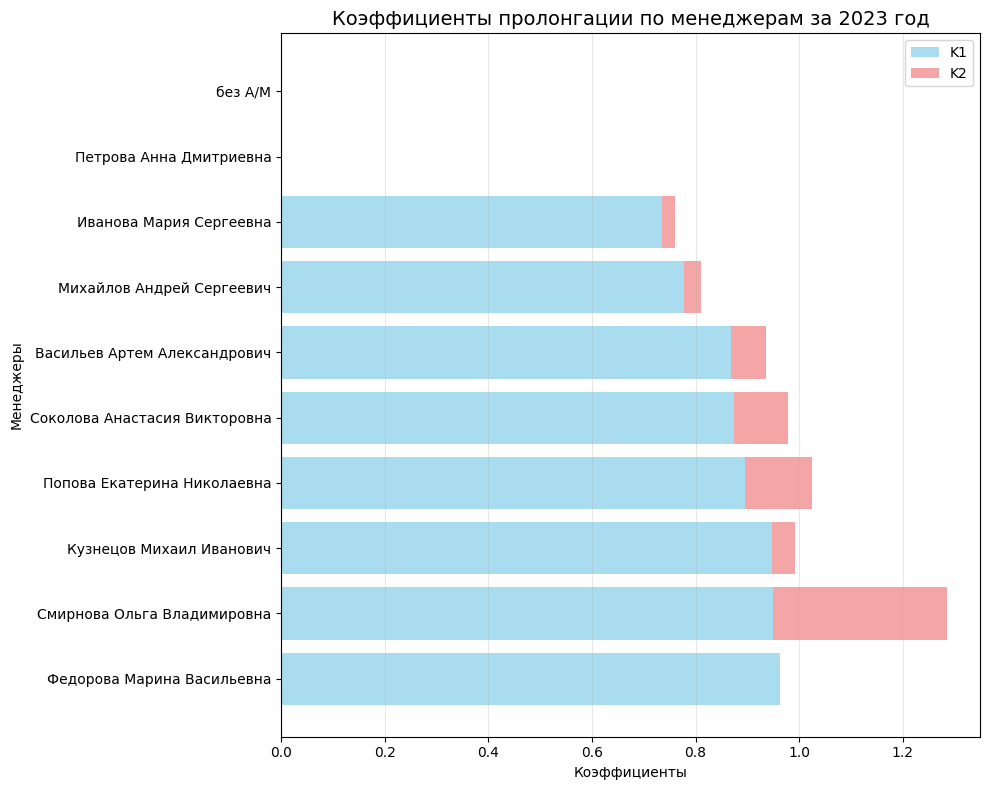

In [90]:
# График коэффициентов за год по всем менеджерам
year = 2023
# Расчет годовых коэффициентов по всем менеджерам
yearly_managers = calc_year_coeffs(df_final, months_for_year, by_manager=True, year=year)

# Сортируем менеджеров по K1 для красивого графика
yearly_managers_sorted = yearly_managers.sort_values('K1', ascending=False)

plt.figure(figsize=(10, 8))
y_pos = range(len(yearly_managers_sorted))

plt.barh(y_pos, yearly_managers_sorted['K1'], alpha=0.7, color='skyblue', label='K1')
plt.barh(y_pos, yearly_managers_sorted['K2'], alpha=0.7, color='lightcoral', label='K2',
         left=yearly_managers_sorted['K1'])

plt.yticks(y_pos, yearly_managers_sorted['Manager'])
plt.title(f'Коэффициенты пролонгации по менеджерам за {year} год', fontsize=14)
plt.xlabel('Коэффициенты')
plt.ylabel('Менеджеры')
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()